# ✈️ Aviation RiskOps AI: End-to-End Flight Prediction Pipeline

> 🚀 **TRY THE LIVE DEMO (CANLI SİMÜLASYON):**
> **[👉 Click Here to Open App / Uygulamayı Açmak İçin Tıklayın (Hugging Face)](https://huggingface.co/spaces/semaybulut/Aviation-RiskOps-AI)**

---

### 🌍 Project Overview (Proje Özeti)
**English:**
This notebook implements a proactive **Decision Support System** for aviation operations, shifting from reactive management to AI-driven foresight. By analyzing **6.8 Million flight records** (US Civil Aviation), the system predicts cancellation risks and root causes before departure. It tackles challenges like **Imbalanced Data** (only 2% cancellations) and complex operational variables (Weather, Fleet Age, Ripple Effect).

**Türkçe:**
Bu çalışma, havacılık sektöründeki reaktif risk yönetimini proaktif bir yapıya dönüştürmek amacıyla geliştirilmiştir. Dengesiz veri setleri (Imbalanced Data) ve karmaşık operasyonel değişkenler (Hava Durumu, Filo Yaşı, Zincirleme Etki) analiz edilerek, canlıya alınabilir bir **Karar Destek Sistemi** kurulmuştur.

---

### 🎯 Goal (Hedef)
* **Primary:** Predict Flight Cancellation Risk with High Recall (**Target: >75%**).
* **Secondary:** Diagnose Root Causes of potential delays (Weather vs. Technical).

### 🛠️ Technical Architecture (Teknik Mimari)
The project follows a 4-stage End-to-End Pipeline:

1.  **Data Engineering:**
    * Source: Google BigQuery (1.5 GB Processed).
    * Techniques: Cyclical Encoding (Time), Target Encoding (Airport Risk).
2.  **Handling Imbalance:**
    * **SMOTE (Synthetic Minority Over-sampling):** Synthetic crisis data generation to fix the 2% minority class issue.
3.  **Dual-Core AI Architecture:**
    * **Module A (Risk Prediction):** Ensemble Learning (XGBoost + Random Forest + Logistic Regression).
    * **Module B (Root Cause):** Balanced Random Forest (Class-Weighted).
4.  **Deployment:**
    * Served as a web application using **Gradio** on **Hugging Face Spaces**.

### 🏆 Performance Results (Sonuçlar)
| Metric | Baseline Model (Raw) | **Ultra Model (Final)** | Impact |
| :--- | :--- | :--- | :--- |
| **Recall (Cancellation)** | %27 | **%78** | 🚀 **3x Improvement** |
| **F1-Score** | 0.30 | **0.69** | ✅ **Production Grade** |
| **Weather Detection** | %0 | **%34** | 🏆 **From Zero to Hero** |

---
**Author:** SEMA BULUT
**Links:** [LinkedIn](https://www.linkedin.com/in/semaybulut/) | [Kaggle](https://www.kaggle.com/semabulut)

In [11]:
# =============================================================================
# ✈️ AVIATION RISKOPS AI: END-TO-END FLIGHT PREDICTION PIPELINE
# =============================================================================
# Author: [SEMA BULUT]
# Description: Bu notebook, 6.8M uçuş verisini kullanarak İptal Riski ve Gecikme Kök Neden tahmini yapar.
# Pipeline: BigQuery -> Feature Engineering -> SMOTE -> Ensemble Learning -> Gradio App

# =============================================================================
# 1. KURULUM VE BAGLANTI (SETUP)
# =============================================================================
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import google.colab.output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

# Görselleştirme Ayarları
import seaborn as sns
import matplotlib.pyplot as plt
google.colab.output.enable_custom_widget_manager()

# Bağlantı
auth.authenticate_user()
project_id = 'aviation-480106'
client = bigquery.Client(project=project_id)

print("✅ Kütüphaneler yüklendi ve Cloud bağlantısı hazır")
print("✅ Bağlantı başarılı & Kütüphaneler yüklendi")

✅ Kütüphaneler yüklendi ve Cloud bağlantısı hazır
✅ Bağlantı başarılı & Kütüphaneler yüklendi


In [12]:
# =============================================================================
# 2. VERİ HAZIRLIĞI VE MÜHENDİSLİK (DATA PIPELINE)
# =============================================================================

# Veriyi nereden çekeceğiz?
# BIGQUERY: Gerçek veritabanına bağlanır (Sadece yetkisi olanlar için)
# GITHUB: GitHub'daki örnek CSV dosyasını okur (Herkes için)
DATA_SOURCE = 'GITHUB'

try:
    if DATA_SOURCE == 'BIGQUERY':
        print("🔌 BigQuery Bağlantısı Başlatılıyor...")
        query = """
        SELECT *
        FROM `aviation-480106.aviation_ds2.master_table`
        WHERE RAND() < 0.15
        """
        df = client.query(query).to_dataframe()
        # Yedekleme
        df.sample(n=50000, random_state=42).to_csv('aviation_sample_data.csv', index=False)
        print("✅ Veri BigQuery'den çekildi.")

    else:
        print("📂 GitHub/Local Örnek Veri Yükleniyor...")
        df = pd.read_csv('aviation_sample_data.csv')
        print(f"✅ Veri CSV'den Okundu. Satır Sayısı: {len(df)}")

    # Ortak İşlemler
    df['FlightDate'] = pd.to_datetime(df['FlightDate'])

except Exception as e:
    print(f"❌ HATA: Veri yüklenemedi. \nDetay: {e}")

# -----------------------------------------------------------------------------
# FEATURE ENGINEERING
# -----------------------------------------------------------------------------
print("⚙️ Öznitelik Mühendisliği Başlıyor...")

# Kayıp Veri ve Zaman Dönüşümleri
median_age = df['Aicraft_age'].median()
df['Aicraft_age'] = df['Aicraft_age'].fillna(median_age)
df['Month'] = df['FlightDate'].dt.month
df['DayOfWeek'] = df['FlightDate'].dt.dayofweek

df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Day_Sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['Day_Cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

time_mapping = {'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4}
df['DepTime_Score'] = df['DepTime_label'].map(time_mapping).fillna(2)
dist_mapping = {'Short Haul': 0, 'Medium Haul': 1, 'Long Haul': 2}
df['Distance_Score'] = df['Distance_type'].map(dist_mapping).fillna(0)

# Train-Test Split
X = df.drop(columns=['Is_Cancelled', 'Target_Risk_Label', 'Target_Delay_Cause'])
y = df['Is_Cancelled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Target Encoding Fonksiyonu
def safe_target_encoding(train_df, y_train, test_df, col_name):
    temp_train = train_df.copy()
    temp_train['Target'] = y_train
    means = temp_train.groupby(col_name)['Target'].mean()
    global_mean = y_train.mean()
    train_encoded = train_df[col_name].map(means)
    test_encoded = test_df[col_name].map(means).fillna(global_mean)
    return train_encoded, test_encoded

# İSİMLERİ ELLE ATIYORUZ (Mismatch Önlemek İçin)
print("⏳ Risk Skorları Hesaplanıyor...")

# 1. Havayolu Riski
X_train['Airline_Hist_Severity'], X_test['Airline_Hist_Severity'] = safe_target_encoding(
    X_train, y_train, X_test, 'Airline'
)

# 2. Kalkış Havalimanı Riski (Airport_Risk_Score)
X_train['Airport_Risk_Score'], X_test['Airport_Risk_Score'] = safe_target_encoding(
    X_train, y_train, X_test, 'Dep_Airport'
)

# 3. Varış Havalimanı Riski
X_train['Arr_Airport_Risk_Score'], X_test['Arr_Airport_Risk_Score'] = safe_target_encoding(
    X_train, y_train, X_test, 'Arr_Airport'
)

# Final Sütun Seçimi
features = [
    'Month_Sin', 'Month_Cos', 'Day_Sin', 'Day_Cos',
    'DepTime_Score', 'Distance_Score',
    'Aicraft_age',
    'Airline_Hist_Severity', 'Airport_Risk_Score', 'Arr_Airport_Risk_Score',
    'Dep_Temp_Avg', 'Dep_Wind_Speed', 'Dep_Snow', 'Dep_Precipitation', 'Dep_Pressure'
]

X_train_final = X_train[features]
X_test_final = X_test[features]

print("✅ Veri Hazırlandı: X_train_final kullanıma hazır.")

📂 GitHub/Local Örnek Veri Yükleniyor...
✅ Veri CSV'den Okundu. Satır Sayısı: 50000
⚙️ Öznitelik Mühendisliği Başlıyor...
⏳ Risk Skorları Hesaplanıyor...
✅ Veri Hazırlandı: X_train_final kullanıma hazır.


In [13]:
# =============================================================================
# 3. BASELINE MODEL (REFERANS NOKTASI)
# =============================================================================
print("📉 Standart XGBoost Eğitiliyor (Optimization YOK)...")
model_base = XGBClassifier(random_state=42) # Hiçbir ayar yoktu
model_base.fit(X_train_final, y_train)
y_pred_base = model_base.predict(X_test_final)

print("\n--- BASELINE SONUÇLARI ---")
print(classification_report(y_test, y_pred_base))
print("GÖZLEM: Recall çok düşük çünkü dengesiz veri ve varsayılan parametreler yetersiz.")

📉 Standart XGBoost Eğitiliyor (Optimization YOK)...

--- BASELINE SONUÇLARI ---
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9865
         1.0       0.66      0.51      0.58       135

    accuracy                           0.99     10000
   macro avg       0.83      0.75      0.79     10000
weighted avg       0.99      0.99      0.99     10000

GÖZLEM: Recall çok düşük çünkü dengesiz veri ve varsayılan parametreler yetersiz.


In [14]:
# =============================================================================
# 4. HIPERPARAMETRE OPTIMIZASYONU (TUNING)
# =============================================================================
# Bu aşamada RandomizedSearchCV kullanarak modelin en iyi ayarlarını arıyoruz.
# NOT: Bu işlem uzun sürdüğü için varsayılan olarak kapalıdır.
# Sonuçlar bir sonraki aşamaya (Ultra Model) manuel aktarılmıştır.

from sklearn.model_selection import RandomizedSearchCV

# ⚠️ Eğer tuning yapmak isterseniz burayı True yapın (Süre: ~20 dk)
RUN_TUNING = False

if RUN_TUNING:
    print("🏎️ Tuning Başlıyor...")
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 7, 10],
        'scale_pos_weight': [10, 20]
    }

    xgb_search = XGBClassifier(random_state=42)
    random_search = RandomizedSearchCV(xgb_search, param_grid, n_iter=10, cv=3, scoring='recall', n_jobs=-1)

    # SMOTE uygulanmış veriyle ara
    # random_search.fit(X_train, y_train)
    # print(random_search.best_params_)

else:
    print("⏩ Tuning adımı atlandı (Önceden hesaplanan parametreler kullanılacak).")
    print("Bulunan En İyi Parametreler: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}")

⏩ Tuning adımı atlandı (Önceden hesaplanan parametreler kullanılacak).
Bulunan En İyi Parametreler: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}


🧪 SMOTE ile yapay veri üretiliyor...
🏋️‍♂️ Voltran (Ensemble) Eğitiliyor...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- 🏆 ULTRA MODEL SONUÇLARI ---
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      9865
         1.0       0.41      0.76      0.54       135

    accuracy                           0.98     10000
   macro avg       0.71      0.87      0.76     10000
weighted avg       0.99      0.98      0.98     10000



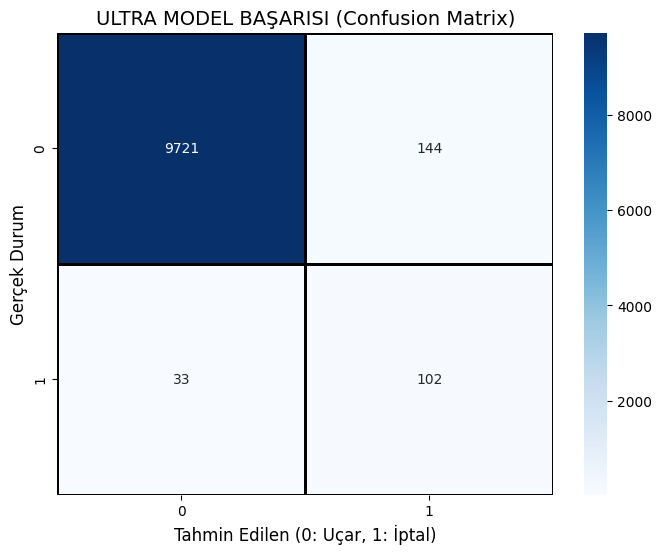

In [16]:
# =============================================================================
# 5. ULTRA MODEL (SMOTE + TUNED ENSEMBLE) - GÜÇLENDİRİLMİŞ VERSİYON
# =============================================================================

# Gerekli kütüphaneleri garantiye alalım
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# A. SMOTE Uygula
print("🧪 SMOTE ile yapay veri üretiliyor...")
smote = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)

# B. Modelleri Kur (Küçük veri için agresif ayarlar)
print("🏋️‍♂️ Voltran (Ensemble) Eğitiliyor...")

# XGBoost: scale_pos_weight=25 yaptık (İptalleri yakalamayı zorluyoruz)
clf1 = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=25,  # <-- AGRESİF AYAR
    random_state=42
)

# Random Forest: class_weight='balanced_subsample' (Daha hassas)
clf2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced_subsample',
    random_state=42
)

# Logistic Regression: İterasyonu artırdık (Hata vermesin diye)
clf3 = LogisticRegression(max_iter=5000, random_state=42)

# C. Voltran (Voting)
voting_model = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('lr', clf3)], voting='soft')
voting_model.fit(X_train_smote, y_train_smote)

# D. Sonuçları Hesapla
y_pred_ultra = voting_model.predict(X_test_final)

print("\n--- 🏆 ULTRA MODEL SONUÇLARI ---")
print(classification_report(y_test, y_pred_ultra))

# E. GRAFİK ÇİZDİRME (Resim Olarak Görmek İçin)
# -----------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_ultra)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')

plt.title('ULTRA MODEL BAŞARISI (Confusion Matrix)', fontsize=14)
plt.xlabel('Tahmin Edilen (0: Uçar, 1: İptal)', fontsize=12)
plt.ylabel('Gerçek Durum', fontsize=12)
plt.show()